#Import stuff

In [1]:
#install Uqq fastbook
# !pip install -Uqq fastbook
import fastbook #import fastbook

from fastbook import *  #import everything from fastbook
from fastai.vision.widgets import *  #import all widgets

###Load Data

In [2]:
#open the bing thing
key = os.environ.get('AZURE_SEARCH_KEY', '72f02eee78f94151a75d95849635bea0')

In [3]:
#use search_images_bing() to bring in the images you'd like
results = search_images_bing(key, 'sloth')
ims = len(results.attrgot('contentUrl'))
ims


150

In [4]:
ims = results.attrgot('contentUrl')

In [5]:
dest = 'images/sloths.jpg'
download_url(ims[127], dest,overwrite=True)

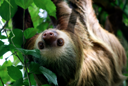

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [18]:
animals_g = 'otter', 'sloth'
path = Path('cute_animals_2')

In [19]:
if not path.exists():
    path.mkdir()
    for o in animals_g:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} baby')
        download_images(dest, urls=results.attrgot('contentUrl'),timeout=20)

In [89]:
fns = get_image_files(path)
fns

(#262) [Path('cute_animals_2/otter/00000047.jpg'),Path('cute_animals_2/otter/00000055.jpg'),Path('cute_animals_2/otter/00000098.png'),Path('cute_animals_2/otter/00000107.jpg'),Path('cute_animals_2/otter/00000036.jpg'),Path('cute_animals_2/otter/00000148.jpg'),Path('cute_animals_2/otter/00000029.jpg'),Path('cute_animals_2/otter/00000112.jpg'),Path('cute_animals_2/otter/00000091.jpg'),Path('cute_animals_2/otter/00000093.jpg')...]

In [74]:
failed = verify_images(fns)
failed

(#0) []

In [75]:
failed.map(Path.unlink)

(#0) []

In [76]:
fns[0]

Path('cute_animals_2/otter/00000047.jpg')

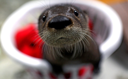

In [77]:
im = Image.open(fns[28])
im.to_thumb(128,128)

#Use Data Loader

In [90]:
babies = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [91]:
dls = babies.dataloaders(path)

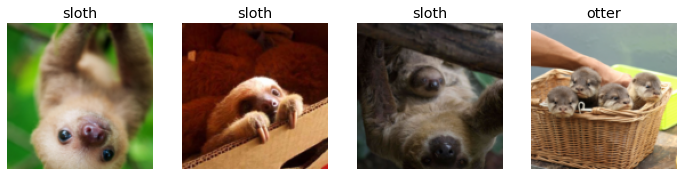

In [92]:
dls.valid.show_batch(max_n=4, nrows=1)

#Augment Data

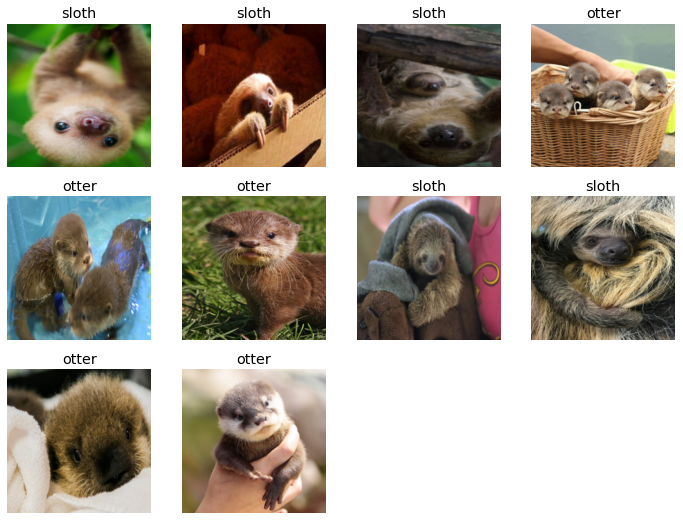

In [93]:
babies = babies.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = babies.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=3)


#Train Model using it to clean your data

In [99]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.114296,1.780603,0.461538,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.325209,0.302557,0.115385,00:07
1,0.223002,0.599169,0.192308,00:07
2,0.183122,0.980900,0.211538,00:07
3,0.155074,1.278053,0.326923,00:07


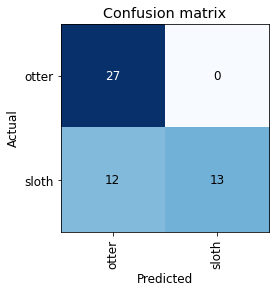

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

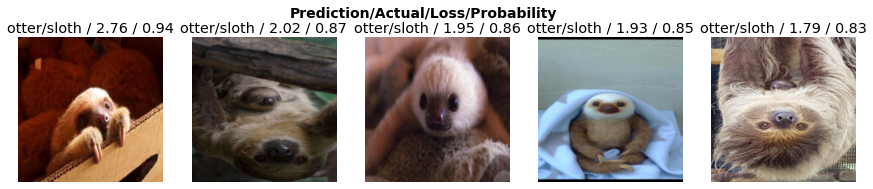

In [96]:
interp.plot_top_losses(5, nrows=1)

In [85]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [87]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [100]:
#export both the model and parameters
learn.export()

In [101]:
#check to see if the path exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [102]:
#load inference learner
learn_inf = load_learner(path/'export.pkl')

In [103]:
#predict one image at a time
learn_inf.predict('images/grizzly.jpg')


('otter', tensor(0), tensor([0.9983, 0.0017]))

In [104]:
#check what the vocab of the output is so you can tell what this means
learn_inf.dls.vocab

['otter', 'sloth']

In [106]:
#create widget to click and upload a file
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

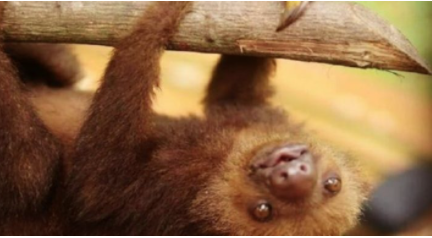

In [108]:
#save image as img
img = PILImage.create(btn_upload.data[-1])


In [109]:
#use an output widget to display the photo uploaded
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [110]:
#run learner on 'img' and save as prediction, index for prediction category
#, probability of correctness of prediction:
pred, pred_idx,probs = learn_inf.predict(img)

In [111]:
#use a label to show prediction info:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediciton: {pred}; Probability: {probs[pred_idx]}; 

#Turn Your data into an app